In [2]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import os
import torch.nn.functional as F
from PIL import Image
import random

In [3]:
def plot_simple_confusion_matrix(model, dataloader, classes):
    model.eval()  # Set the model to evaluation mode
    y_true = []  # List to store true labels
    y_pred = []  # List to store predicted labels

    # Iterate over the data loader and get predictions
    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, labels in dataloader:  # Iterate through batches in the dataloader
            outputs = model(images)  # Forward pass through the model
            _, predicted = torch.max(outputs, 1)  # Get predicted class (index of max output)
            # This line finds the class with the highest predicted probability. torch.max() returns two values: 
            # the maximum value and the index of that value. We only need the index, which is the predicted class
            y_true.extend(labels.cpu().numpy())  # Append true labels to y_true
            y_pred.extend(predicted.cpu().numpy())  # Append predicted labels to y_pred
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy
    correct_predictions = np.sum(np.array(y_true) == np.array(y_pred))  # Count correct predictions
    accuracy = correct_predictions / len(y_true)  # Accuracy is correct predictions divided by total number of samples
    #print(f'Accuracy: {accuracy * 100:.2f}%')  # Print accuracy in percentage

    # Plot the confusion matrix
    plt.figure(figsize=(3, 3))  # Set figure size
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Display the confusion matrix as an image
    plt.title("Confusion Matrix")
    # plt.colorbar()  # Display a color bar

    # Add labels for the axes
    tick_marks = np.arange(len(classes))  # Generate tick positions for each class
    plt.xticks(tick_marks, classes, rotation=45)  # Set the x-axis ticks (predicted labels) and rotate the labels by 45 degrees
    plt.yticks(tick_marks, classes)  # Set the y-axis ticks (true labels)

    # Display the values inside the matrix
    for i in range(len(classes)):  # Loop over each class
        for j in range(len(classes)):  # Loop over each predicted class
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()  # Adjust layout to prevent labels from being cut off
    plt.show()  # Display the plot

    return accuracy

### Data Preprocessing

In [4]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Transformations for the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to a fixed size of 128x128 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor and scale pixel values to [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image channels = colored (R, G, B) to have mean 0.5 and std 0.5
])

# Loading the dataset using ImageFolder
dataset_path = '/home/laura/Desktop/OsloUni/ML/Project3/archive/'
dataset = datasets.ImageFolder(os.path.join(dataset_path), transform=transform)
# The ImageFolder class assumes the dataset is organized into subfolders representing class labels.
# The `transform` argument ensures that all images undergo the specified transformations.

# Splitting the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% of the dataset for training
val_size = int(0.15 * len(dataset))   # 15% of the dataset for validation
test_size = len(dataset) - train_size - val_size  # Remaining 15% for testing

# Perform the actual split
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Creating DataLoaders for each set
trainloader = DataLoader(train_set, batch_size=32, shuffle=True)  # Shuffle the training data for randomness
valloader = DataLoader(val_set, batch_size=32, shuffle=False)     # No shuffling for validation
testloader = DataLoader(test_set, batch_size=32, shuffle=False)   # No shuffling for testing

# Defining the class labels
classes = ['benign', 'malignant']  # The two categories of images in this dataset
# These labels correspond to the subfolder names in the dataset directory structure.

# Sizes of training, validation, and test sets
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

# Check the number of batches 
print(f"Number of batches in training set: {len(trainloader)}")
print(f"Number of batches in validation set: {len(valloader)}")
print(f"Number of batches in test set: {len(testloader)}")

# Size of one batch from the trainloader
example_batch = next(iter(trainloader))

# size of one batch
print(f"Batch input shape: {example_batch[0].shape}")  # Shape of the images in the batch [batch_size, 3, 128, 128] 
# 32 immagini, ciascuna con 3 canali (RGB), 128x128 pixel
print(f"Batch label shape: {example_batch[1].shape}")  # Shape of the labels in the batch

Training set size: 2307
Validation set size: 494
Test set size: 496
Number of batches in training set: 73
Number of batches in validation set: 16
Number of batches in test set: 16
Batch input shape: torch.Size([32, 3, 128, 128])
Batch label shape: torch.Size([32])


In [5]:
def training_cnn(model, trainloader, valloader, testloader, classes, optimizer, model_name, epochs = 30):
    # Set seed for reproducibility
    SEED = 42
    torch.manual_seed(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Confusion matrix on validation set before training the model
    accuracy_before = plot_simple_confusion_matrix(model, valloader, classes)
    print("Accuracy before training on validation set: ",accuracy_before)

    ### MODEL'S  TRAINING  ###

    train_accuracies = []  # List to store training accuracies for each epoch
    val_accuracies = []  # List to store validation accuracies for each epoch

    # Loss function
    criterion = nn.CrossEntropyLoss()  # Define the loss function: Cross-Entropy Loss for classification tasks

    for epoch in range(epochs):  # Loop through 30 epochs
        model.train()  # Set the model to training mode (important for layers like dropout and batch normalization)
        running_loss = 0.0  # Initialize running loss to track the loss during the epoch
        correct_train = 0  # Variable to count the number of correct predictions on the training set
        total_train = 0  # Total number of training samples processed
    
        for i, data in enumerate(trainloader, 0):  # Iterate through the training data loader
            inputs, labels = data  # Get the images and labels from the current batch
            optimizer.zero_grad()  # Zero the gradients to avoid accumulation from previous iterations
            outputs = model(inputs)  # Forward pass through the network
            loss = criterion(outputs, labels)  # Calculate the loss using the predicted outputs and true labels
            loss.backward()  # Backpropagation: Compute the gradients
            optimizer.step()  # Update the weights using the computed gradients
    
            running_loss += loss.item()  # Add the current batch's loss to the running loss
    
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)  # Get the predicted class by selecting the class with the highest probability
            total_train += labels.size(0)  # Update the total number of samples processed
            correct_train += (predicted == labels).sum().item()  # Update the count of correct predictions
    
        # Calculate the accuracy for the training set
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)  # Store the training accuracy for this epoch
    
        # Validation accuracy calculation
        model.eval()  # Set the model to evaluation mode (important for layers like dropout)
        correct_val = 0  # Variable to count correct predictions on the validation set
        total_val = 0  # Total number of validation samples processed
    
        with torch.no_grad():  # Disable gradient calculation, as we're not training here
            for val_data in valloader:  # Iterate through the validation data loader
                val_inputs, val_labels = val_data  # Get the images and labels from the validation set
                val_outputs = model(val_inputs)  # Get the model's predictions for the validation set
                _, val_predicted = torch.max(val_outputs, 1)  # Get the predicted classes
                total_val += val_labels.size(0)  # Update the total number of validation samples processed
                correct_val += (val_predicted == val_labels).sum().item()  # Update the count of correct predictions
    
        # Calculate the accuracy for the validation set
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)  # Store the validation accuracy for this epoch
    
        # Print the accuracy for this epoch
        print(f'Epoch {epoch + 1}: Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')


    model_path = f"./skin_lesion_classifier_{model_name}.pth"  # Path where the model will be saved
    torch.save(model.state_dict(), model_path)  # Save the model's state_dict (weights) to the specified path
    print(f"Model saved in {model_path}")  # Print the confirmation message

    # Plotting train and validation accuracy along epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 31), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, 31), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model_path


def cnn_performance(model, valloader, testloader, classes):    
    # Confusion matrix on validation after training
    accuracy_after = plot_simple_confusion_matrix(model, valloader, classes)

    # VALIDATION
    # Class-wise accuracy
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in valloader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
    
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class on Validation: {classname:5s} is {accuracy:.1f} %')

    # Total accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Total Accuracy on Validation set: {100 * correct / total:.2f}%')

    # TEST
    # Class-wise accuracy
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
    
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class on Test set: {classname:5s} is {accuracy:.1f} %')

    # Total accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Total Accuracy on Test set: {100 * correct / total:.2f}%')

## MODEL INITIALIZATION

In [ ]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining CNN
class Net(nn.Module):
    # layers of the neural network:
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # First convolutional layer (input: 3 channels, output: 16 channels, kernel size: 3x3)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with a 2x2 window and stride of 2
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # Second convolutional layer (input: 16 channels, output: 32 channels, kernel size: 3x3)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # Fully connected layer (input size: 32*32*32, output size: 128)
        self.fc2 = nn.Linear(128, 2)  # Fully connected layer (input size: 128, output size: 2 for binary classification)

    def forward(self, x):
        # Forward pass through the network
        x = self.pool(F.relu(self.conv1(x)))  # Apply ReLU activation after conv1 and then max pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply ReLU activation after conv2 and then max pooling
        x = torch.flatten(x, 1)  # Flatten the output to feed into the fully connected layers
        x = F.relu(self.fc1(x))  # Apply ReLU activation after the first fully connected layer
        x = self.fc2(x)  # Output layer (no activation here, as we're using CrossEntropyLoss which combines softmax)
        return x

# ADAM

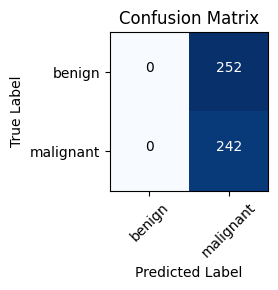

Accuracy before training on validation set:  0.4898785425101215
Epoch 1: Train Accuracy: 74.90%, Val Accuracy: 79.35%
Epoch 2: Train Accuracy: 81.27%, Val Accuracy: 79.76%
Epoch 3: Train Accuracy: 83.70%, Val Accuracy: 79.96%
Epoch 4: Train Accuracy: 84.57%, Val Accuracy: 80.97%
Epoch 5: Train Accuracy: 86.52%, Val Accuracy: 79.76%
Epoch 6: Train Accuracy: 88.25%, Val Accuracy: 84.62%
Epoch 7: Train Accuracy: 90.46%, Val Accuracy: 82.79%
Epoch 8: Train Accuracy: 92.59%, Val Accuracy: 83.81%
Epoch 9: Train Accuracy: 94.10%, Val Accuracy: 82.79%
Epoch 10: Train Accuracy: 95.10%, Val Accuracy: 83.60%
Epoch 11: Train Accuracy: 97.62%, Val Accuracy: 83.60%
Epoch 12: Train Accuracy: 97.44%, Val Accuracy: 83.20%
Epoch 13: Train Accuracy: 99.13%, Val Accuracy: 84.21%
Epoch 14: Train Accuracy: 99.31%, Val Accuracy: 83.60%
Epoch 15: Train Accuracy: 99.52%, Val Accuracy: 82.19%
Epoch 16: Train Accuracy: 98.83%, Val Accuracy: 82.19%
Epoch 17: Train Accuracy: 99.74%, Val Accuracy: 81.78%
Epoch 18: 

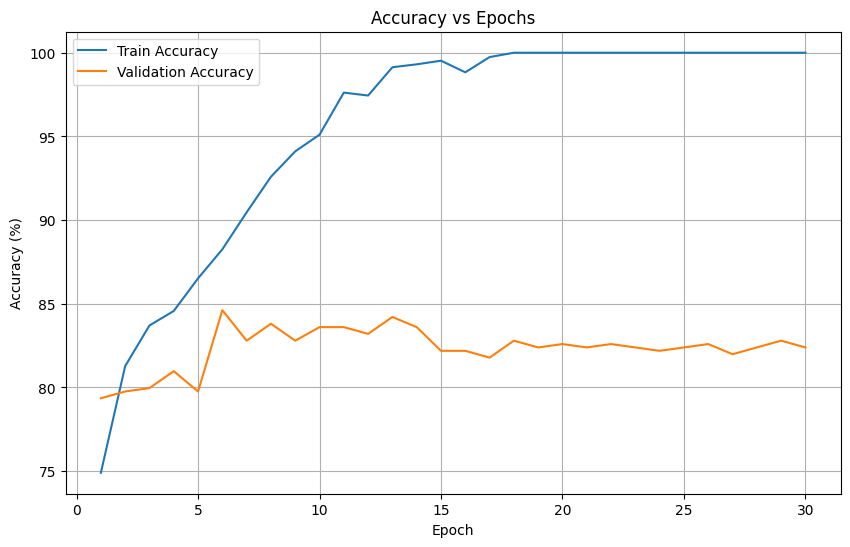

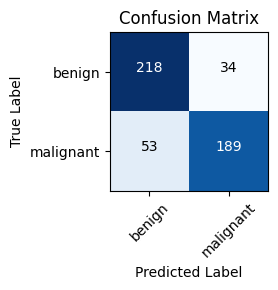

Accuracy for class on Validation: benign is 86.5 %
Accuracy for class on Validation: malignant is 78.1 %
Total Accuracy on Validation set: 82.39%
Accuracy for class on Test set: benign is 85.6 %
Accuracy for class on Test set: malignant is 80.8 %
Total Accuracy on Test set: 83.47%


In [6]:
netADAM = Net()

# Optimizer
optimizer = optim.Adam(netADAM.parameters(), lr=0.001)  # Define the optimizer: Adam optimizer with learning rate 0.001

model_path = training_cnn(netADAM, trainloader, valloader, testloader, classes, optimizer, model_name = "netAdam001", epochs = 30)

# Loading trained model for final evaluation
netADAM = Net()
netADAM.load_state_dict(torch.load(model_path, weights_only=True))
netADAM.eval()
# print("Model loaded for evaluation")
cnn_performance(netADAM, valloader, testloader, classes)

## RMSprop

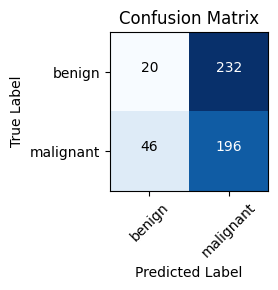

Accuracy before training on validation set:  0.43724696356275305
Epoch 1: Train Accuracy: 75.16%, Val Accuracy: 76.11%
Epoch 2: Train Accuracy: 80.10%, Val Accuracy: 79.35%
Epoch 3: Train Accuracy: 81.84%, Val Accuracy: 77.33%
Epoch 4: Train Accuracy: 84.14%, Val Accuracy: 67.81%
Epoch 5: Train Accuracy: 84.79%, Val Accuracy: 78.95%
Epoch 6: Train Accuracy: 86.04%, Val Accuracy: 78.34%
Epoch 7: Train Accuracy: 87.34%, Val Accuracy: 75.51%
Epoch 8: Train Accuracy: 88.30%, Val Accuracy: 81.58%
Epoch 9: Train Accuracy: 89.47%, Val Accuracy: 80.16%
Epoch 10: Train Accuracy: 90.98%, Val Accuracy: 83.60%
Epoch 11: Train Accuracy: 93.63%, Val Accuracy: 79.96%
Epoch 12: Train Accuracy: 94.41%, Val Accuracy: 83.81%
Epoch 13: Train Accuracy: 94.80%, Val Accuracy: 82.39%
Epoch 14: Train Accuracy: 97.27%, Val Accuracy: 84.62%
Epoch 15: Train Accuracy: 97.96%, Val Accuracy: 82.79%
Epoch 16: Train Accuracy: 97.96%, Val Accuracy: 80.77%
Epoch 17: Train Accuracy: 96.27%, Val Accuracy: 82.59%
Epoch 18:

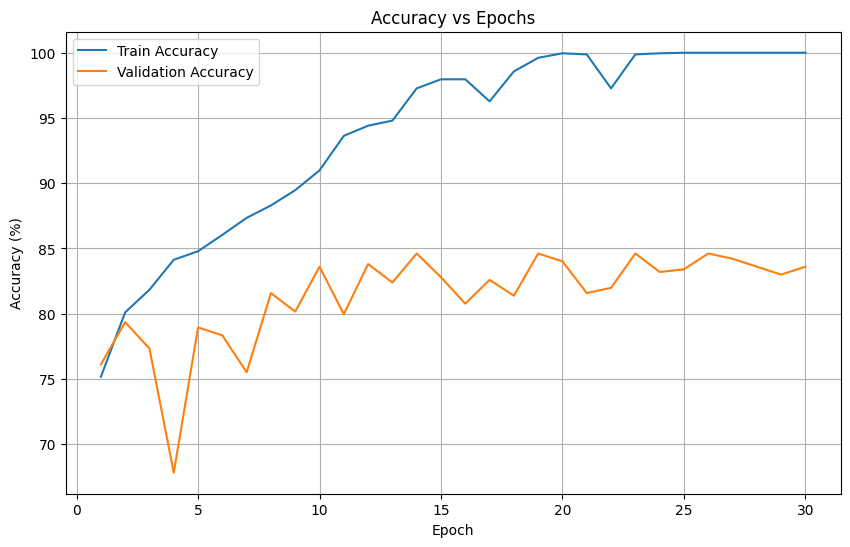

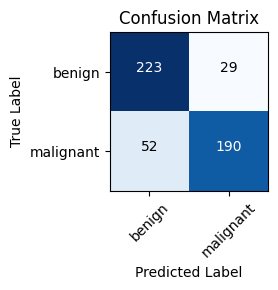

Accuracy for class on Validation: benign is 88.5 %
Accuracy for class on Validation: malignant is 78.5 %
Total Accuracy on Validation set: 83.60%
Accuracy for class on Test set: benign is 89.5 %
Accuracy for class on Test set: malignant is 77.2 %
Total Accuracy on Test set: 84.07%


In [7]:
netRMSprop = Net()

# Optimizer
optimizer = optim.RMSprop(netRMSprop.parameters(), lr=0.001, alpha=0.99)

model_path = training_cnn(netRMSprop, trainloader, valloader, testloader, classes, optimizer, model_name = "netRMSprop001", epochs = 30)

# Loading trained model for final evaluation
netRMSprop = Net()
netRMSprop.load_state_dict(torch.load(model_path, weights_only=True))
netRMSprop.eval()
# print("Model loaded for evaluation")
cnn_performance(netRMSprop, valloader, testloader, classes)

## Adagrad

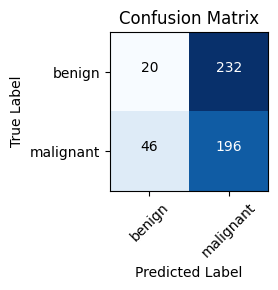

Accuracy before training on validation set:  0.43724696356275305
Epoch 1: Train Accuracy: 73.65%, Val Accuracy: 77.73%
Epoch 2: Train Accuracy: 78.67%, Val Accuracy: 77.33%
Epoch 3: Train Accuracy: 80.02%, Val Accuracy: 74.90%
Epoch 4: Train Accuracy: 80.49%, Val Accuracy: 76.32%
Epoch 5: Train Accuracy: 81.62%, Val Accuracy: 73.89%
Epoch 6: Train Accuracy: 82.53%, Val Accuracy: 78.54%
Epoch 7: Train Accuracy: 82.27%, Val Accuracy: 75.30%
Epoch 8: Train Accuracy: 82.49%, Val Accuracy: 76.72%
Epoch 9: Train Accuracy: 83.18%, Val Accuracy: 78.34%
Epoch 10: Train Accuracy: 83.31%, Val Accuracy: 78.74%
Epoch 11: Train Accuracy: 84.01%, Val Accuracy: 81.58%
Epoch 12: Train Accuracy: 84.22%, Val Accuracy: 80.16%
Epoch 13: Train Accuracy: 84.79%, Val Accuracy: 79.55%
Epoch 14: Train Accuracy: 84.70%, Val Accuracy: 80.97%
Epoch 15: Train Accuracy: 84.70%, Val Accuracy: 80.97%
Epoch 16: Train Accuracy: 84.18%, Val Accuracy: 81.58%
Epoch 17: Train Accuracy: 85.87%, Val Accuracy: 79.15%
Epoch 18:

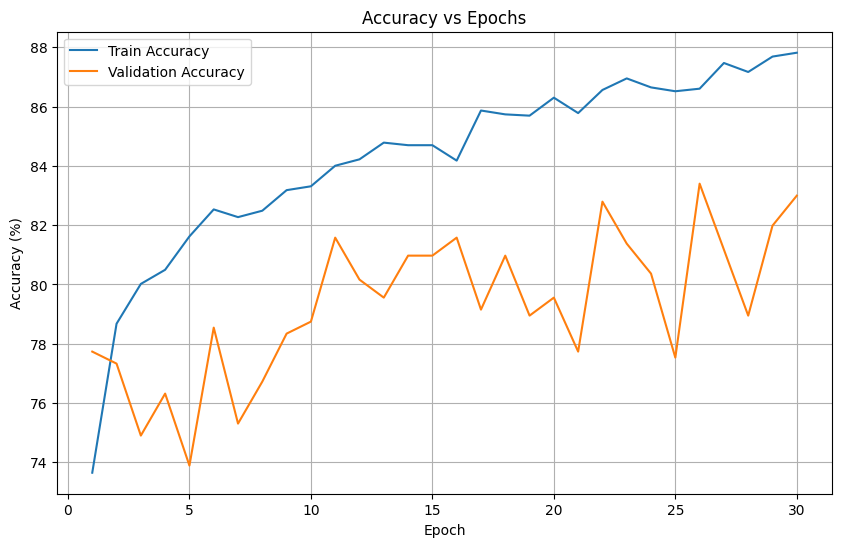

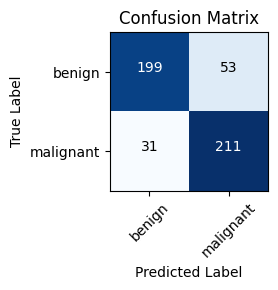

Accuracy for class on Validation: benign is 79.0 %
Accuracy for class on Validation: malignant is 87.2 %
Total Accuracy on Validation set: 83.00%
Accuracy for class on Test set: benign is 81.9 %
Accuracy for class on Test set: malignant is 87.7 %
Total Accuracy on Test set: 84.48%


In [8]:
netAdagrad = Net()

# Optimizer
optimizer = optim.Adagrad(netAdagrad.parameters(), lr=0.001)

model_path = training_cnn(netAdagrad, trainloader, valloader, testloader, classes, optimizer, model_name = "netAdagrad001", epochs = 30)

# Loading trained model for final evaluation
netAdagrad = Net()
netAdagrad.load_state_dict(torch.load(model_path, weights_only=True))
netAdagrad.eval()
# print("Model loaded for evaluation")
cnn_performance(netAdagrad, valloader, testloader, classes)

## SGD

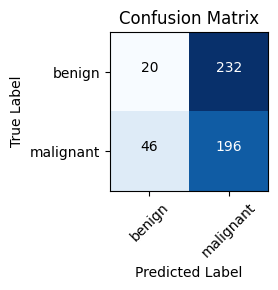

Accuracy before training on validation set:  0.43724696356275305
Epoch 1: Train Accuracy: 59.17%, Val Accuracy: 73.89%
Epoch 2: Train Accuracy: 74.38%, Val Accuracy: 76.72%
Epoch 3: Train Accuracy: 77.59%, Val Accuracy: 78.34%
Epoch 4: Train Accuracy: 78.93%, Val Accuracy: 78.54%
Epoch 5: Train Accuracy: 79.54%, Val Accuracy: 79.76%
Epoch 6: Train Accuracy: 80.36%, Val Accuracy: 77.33%
Epoch 7: Train Accuracy: 80.19%, Val Accuracy: 78.14%
Epoch 8: Train Accuracy: 81.06%, Val Accuracy: 79.76%
Epoch 9: Train Accuracy: 81.79%, Val Accuracy: 81.38%
Epoch 10: Train Accuracy: 82.31%, Val Accuracy: 80.36%
Epoch 11: Train Accuracy: 82.70%, Val Accuracy: 78.95%
Epoch 12: Train Accuracy: 83.14%, Val Accuracy: 79.96%
Epoch 13: Train Accuracy: 83.31%, Val Accuracy: 80.77%
Epoch 14: Train Accuracy: 83.62%, Val Accuracy: 79.15%
Epoch 15: Train Accuracy: 84.22%, Val Accuracy: 80.97%
Epoch 16: Train Accuracy: 83.57%, Val Accuracy: 80.57%
Epoch 17: Train Accuracy: 83.88%, Val Accuracy: 79.35%
Epoch 18:

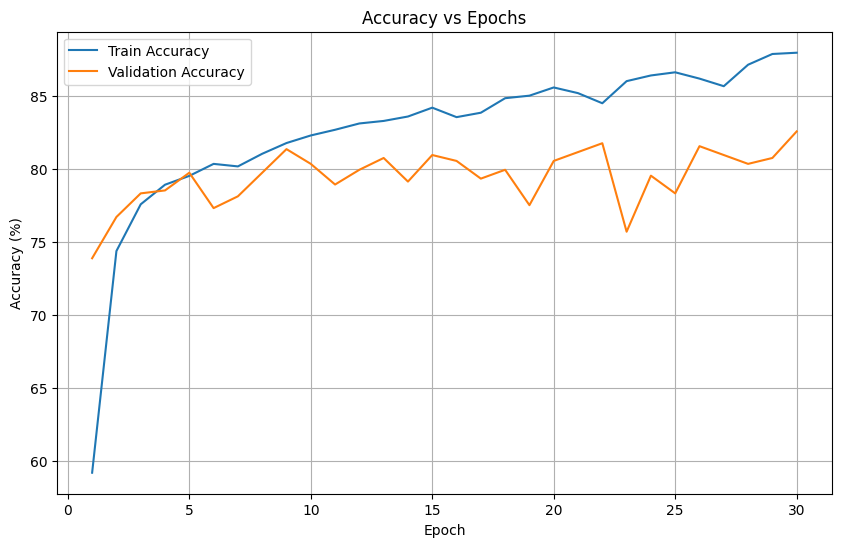

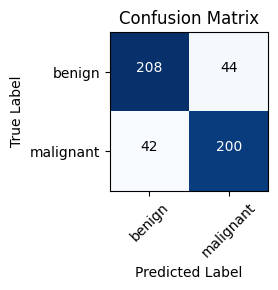

Accuracy for class on Validation: benign is 82.5 %
Accuracy for class on Validation: malignant is 82.6 %
Total Accuracy on Validation set: 82.59%
Accuracy for class on Test set: benign is 81.6 %
Accuracy for class on Test set: malignant is 85.4 %
Total Accuracy on Test set: 83.27%


In [9]:
netSGD = Net()

# Optimizer
optimizer = optim.SGD(netSGD.parameters(), lr=0.001, momentum=0.9)

model_path = training_cnn(netSGD, trainloader, valloader, testloader, classes, optimizer, model_name = "netSGD001", epochs = 30)

# Loading trained model for final evaluation
netSGD = Net()
netSGD.load_state_dict(torch.load(model_path, weights_only=True))
netSGD.eval()
# print("Model loaded for evaluation")
cnn_performance(netSGD, valloader, testloader, classes)